# Robot-dance model with optimal vaccination

In [1]:
import numpy as np
import gekko as gk
import matplotlib.pyplot as plt
%matplotlib inline

Consider the problem 

\begin{align*}
    \min_{u \in C^{\infty}(\mathbb{R}_{+})} &\sum_{i=1}^K c_v  V_i(T) + c_h H_i(T), \\[0.5px]
    \text{s.a. } &V_i(t_d+1) - V_i(t_d)  \le u_i^{\max}, i = 1,\dots, K, t_d = 0, \dots, T-1. \\[0.5px]
    &\sum_{j=1}^K V_i(t) \le D(t), t \in [0,T] \rightarrow \text{choose }t=7,14,\dots,T.\\[0.5px] 
    &u_i \in [0,1], i = 1,\dots,K \rightarrow \text{Is this really?}\\[0.5px] 
    &\frac{dS_i}{dt} = -\alpha(t) \beta_i S_i I_i - (1-\alpha(t)) S_i \sum_{j=1}^K \beta_j p_{ij} I_j^{\mathrm{eff}} - u_i S_i \\
    &\frac{dE_i}{dt} = \alpha(t) \beta_i S_i I_i + (1-\alpha(t)) S_i \sum_{j=1}^K \beta_j p_{ij} I_j^{\mathrm{eff}} - \tau E_i - u_i E_i \\
    &\frac{dI_i}{dt} = \tau E_i - \gamma I_i \\
    &\frac{dR_i}{dt} = \gamma I_i - u_i R_i \\
    &\frac{dH_i}{dt} = r_h I_i \\
    &\frac{dV_i}{dt} = u_i(t) \cdot (S_i + E_i + R_i) \\
    &S_i(0) = s_{i0}, E_i(0) = e_{i0}, I_i(0) = i_{i0}, R_i(0) = r_{i0}, H_i(0) = 0, V_i(0) = 0,
\end{align*}

In [2]:
def optimal_control_problem(parameters):
    
    # Gekko object
    m = gk.GEKKO()
    
    # Including the time
    T = parameters['T']
    npd = 10
    n_points = npd*T + 1
    m.time = np.linspace(0, T, n_points)

    # Number of cities
    populations = parameters['populations']
    K = len(populations)

    p = parameters['p_vector']
    p_matrix = np.eye(K)
    p_matrix[1:,0] = p
    p_matrix[1:, 1:] -= np.diag(p)
    population_eff = populations @ p_matrix

    beta = parameters['beta']

    # Initial values
    e0 = np.array([parameters['e0']]+[1e-8]*(K-1))
    s0 = np.ones(K) - e0
    i0 = np.zeros(K)
    r0 = np.zeros(K)
    v0 = np.zeros(K)
    h0 = np.zeros(K)

    # Including the variables
    s = m.Array(m.Var, K)
    e = m.Array(m.Var, K)
    i = m.Array(m.Var, K)
    r = m.Array(m.Var, K)
    v = m.Array(m.Var, K)
    h = m.Array(m.Var, K)
    u = m.Array(m.MV, K)
    for city in range(K):
        s[city].value = s0[city]
        e[city].value = e0[city]
        i[city].value = i0[city]
        r[city].value = r0[city]
        v[city].value = v0[city]
        h[city].value = h0[city]

        u[city].value = 1.0
        u[city].STATUS = 1
        u[city].DCOST = 0
        u[city].lower = 0.0
        u[city].upper = 1.0
        
    # Constraints
    u_max = parameters['u_max']
    week_max = parameters['week_max']
    
    # Constants
    cv = m.Const(parameters['cv'])
    ch = m.Const(parameters['ch'])
    rh = m.Const(parameters['rh'])
    alpha = m.Const(parameters['alpha'])
    tau = m.Const(parameters['tau'])
    gamma = m.Const(parameters['gamma'])
    P = m.Array(m.Const, (K,K))
    B = m.Array(m.Const, K)
    N = m.Array(m.Const, (K,K))
    E_inv = m.Array(m.Const, (K,K))
    for city1 in range(K):
        for city2 in range(K):
            P[city1, city2].value = p_matrix[city1, city2]
        B[city1].value = beta[city1]
        if city1 == city2:
            N[city1,city1].value = populations[city1]
            E_inv[city1,city1].value = 1/population_eff[city1]
        else:
            N[city1,city2].value = 0.0
            E_inv[city1,city2].value = 0.0       

    # Maximizing 
    obj_points = np.zeros(n_points)
    obj_points[-1] = 1.0
    final = m.Param(value=obj_points)
    m.Obj(cv*v.sum()*final + ch*h.sum()*final)

    # ODE equations
    for city in range(K):
        m.Equation(s[city].dt() == -s[city] * (alpha*B[city]*i[city] + (1-alpha)*(beta*P[city,:]*(E_inv@P.T@N@i)).sum() + u[city]))
        m.Equation(e[city].dt() == s[city] * (alpha*B[city]*i[city] + (1-alpha)*(beta*P[city,:]*(E_inv@P.T@N@i)).sum()) - (tau+u[city])*e[city])
        m.Equation(i[city].dt() == tau*e[city] - gamma*i[city])
        m.Equation(r[city].dt() == gamma*i[city] - u[city]*r[city])
        m.Equation(v[city].dt() == u[city]*(s[city] + e[city] + r[city]))
        m.Equation(h[city].dt() == rh*i[city])
        
#        for day in range(T):
#            obj_points1 = np.zeros(n_points)
#            obj_points[npd*day] = -
#            obj_points[npd*(day+1)] = 1.0
#            param_diff = m.Param(value=obj_points)
#            m.Equation(v[city]*param_diff <= u_max[city])
           
        # Not everyone is taking the vaccine
        m.Equation(v[city]*final <= 0.9)
#            
    for week in range(T//7):
        obj_points = np.zeros(n_points)
        obj_points[npd*7*(week+1)] = 1.0
        param_diff = m.Param(value=obj_points)
        m.Equation(v.sum()*param_diff <= week_max[week])
        
    # Solving
    m.options.IMODE = 6
    m.solve()
    
    return m.time, s, e, i, r, v, h, u

Enjoy the experiments!

In [61]:
populations = np.array([1e6, 1e4, 1e4, 1e4, 1e4])
p_vector = np.array([0.3, 0.2, 0.1, 0.4])
beta = np.array([0.35, 0.2, 0.25, 0.15, 0.1])
alpha = 2/3
tau = 1/3
gamma = 1/5

parameters = {'T': 14, 'populations': populations, 'p_vector': p_vector,
              'beta': beta, 'alpha': alpha, 'tau': tau, 'gamma': gamma, 
              'e0': 100/populations[0], 
              'cv': 0.001, 'ch': 10000, 'rh': 0.1,
              'u_max': np.array([1/(2*7*40), 1/(10*7*40), 1/(10*7*40), 1/(10*7*40), 1/(10*7*40)]),
              'week_max': np.array([1/40, 1/40])}

t, s, e, i, r, v, h, u = optimal_control_problem(parameters)

apm 189.125.124.24_gk_model15 <br><pre> ----------------------------------------------------------------
 APMonitor, Version 1.0.1
 APMonitor Optimization Suite
 ----------------------------------------------------------------
 
 
 --------- APM Model Size ------------
 Each time step contains
   Objects      :            0
   Constants    :           86
   Variables    :           36
   Intermediates:            0
   Connections  :            0
   Equations    :           31
   Residuals    :           31
 
 Number of state variables:          11900
 Number of total equations: -        11200
 Number of slack variables: -            0
 ---------------------------------------
 Degrees of freedom       :            700
 
 **********************************************
 Dynamic Control with Interior Point Solver
 **********************************************
  
  
 Info: Exact Hessian

******************************************************************************
This program contains Ip

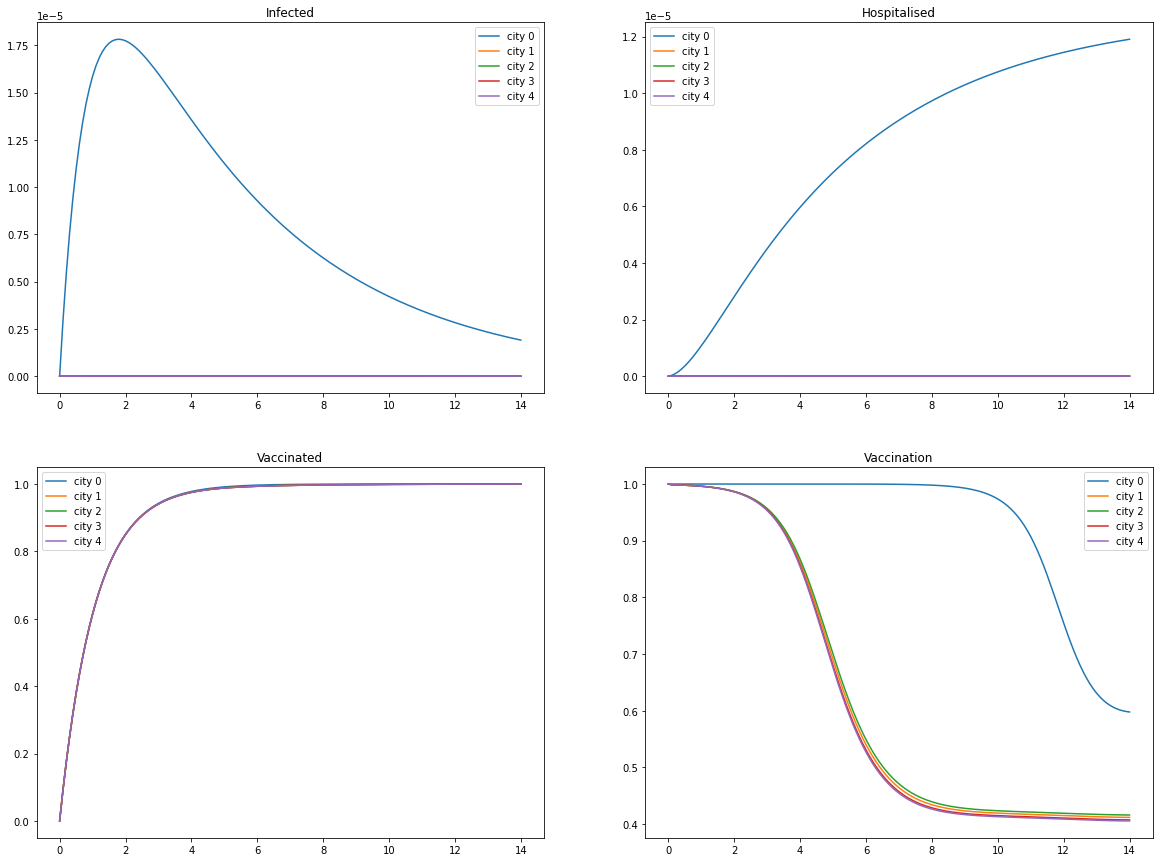

In [62]:
fig, ax = plt.subplots(2,2, figsize=(20,15))

for city in range(len(populations)):
    ax[0,0].plot(t, i[city], label='city {}'.format(city))
    ax[0,1].plot(t, h[city], label='city {}'.format(city))
    ax[1,0].plot(t, v[city], label='city {}'.format(city))
    ax[1,1].plot(t, u[city], label='city {}'.format(city))
    
ax[0,0].set_title('Infected')
ax[0,1].set_title('Hospitalised')
ax[1,0].set_title('Vaccinated')
ax[1,1].set_title('Vaccination')

ax[0,0].legend()
ax[0,1].legend()
ax[1,0].legend()
ax[1,1].legend()

plt.show()

In [3]:
populations = np.array([1e6, 1e4, 1e4, 1e4, 1e4])
p_vector = np.array([0.3, 0.2, 0.1, 0.4])
beta = np.array([0.35, 0.2, 0.25, 0.15, 0.1])
alpha = 2/3
tau = 1/3
gamma = 1/5

parameters = {'T': 28, 'populations': populations, 'p_vector': p_vector,
              'beta': beta, 'alpha': alpha, 'tau': tau, 'gamma': gamma, 
              'e0': 100/populations[0], 
              'cv': 0.001, 'ch': 10000, 'rh': 0.1,
              'u_max': np.array([1/(2*7*40), 1/(10*7*40), 1/(10*7*40), 1/(10*7*40), 1/(10*7*40)]),
              'week_max': np.array([1/4, 2/4, 3/4, 4/4])}

t, s, e, i, r, v, h, u = optimal_control_problem(parameters)

apm 189.125.124.24_gk_model0 <br><pre> ----------------------------------------------------------------
 APMonitor, Version 1.0.1
 APMonitor Optimization Suite
 ----------------------------------------------------------------
 
 
 --------- APM Model Size ------------
 Each time step contains
   Objects      :            0
   Constants    :           86
   Variables    :           49
   Intermediates:            0
   Connections  :            0
   Equations    :           40
   Residuals    :           40
 
 Number of state variables:          26320
 Number of total equations: -        24920
 Number of slack variables: -         2520
 ---------------------------------------
 Degrees of freedom       :          -1120
 
 * Warning: DOF <= 0
 **********************************************
 Dynamic Control with Interior Point Solver
 **********************************************
  
  
 Info: Exact Hessian

******************************************************************************
This

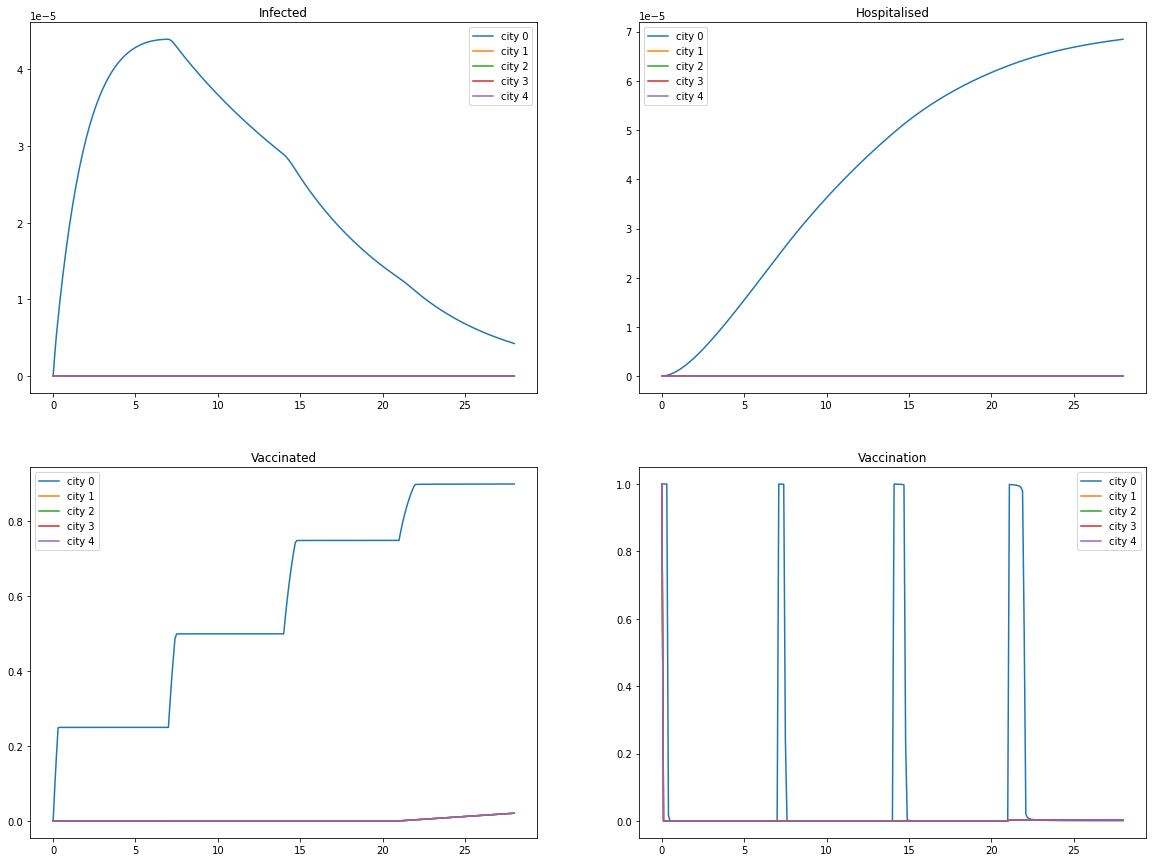

In [4]:
fig, ax = plt.subplots(2,2, figsize=(20,15))

for city in range(len(populations)):
    ax[0,0].plot(t, i[city], label='city {}'.format(city))
    ax[0,1].plot(t, h[city], label='city {}'.format(city))
    ax[1,0].plot(t, v[city], label='city {}'.format(city))
    ax[1,1].plot(t, u[city], label='city {}'.format(city))
    
ax[0,0].set_title('Infected')
ax[0,1].set_title('Hospitalised')
ax[1,0].set_title('Vaccinated')
ax[1,1].set_title('Vaccination')

ax[0,0].legend()
ax[0,1].legend()
ax[1,0].legend()
ax[1,1].legend()

plt.show()